In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import pydot
import pydotplus 
from IPython.display import Image
from sklearn import tree

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.externals.six import StringIO  
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, accuracy_score
from sklearn.datasets import load_iris


%matplotlib inline
# plt.style.use('seaborn')
%cd C:\Users\yo\Documents\ML_and_Python\ML_and_Python_books\ISLR\ISLR-python\Notebooks\Data

C:\Users\yo\Documents\ML_and_Python\ML_and_Python_books\ISLR\ISLR-python\Notebooks\Data


In [2]:
# This function creates images of tree models using pydot
def print_tree(estimator, features, class_names=None, filled=True):
    color = filled
    classn = class_names
    
    dot_data = StringIO()
    export_graphviz(estimator, out_file=dot_data, feature_names=features, class_names=class_names, filled=filled)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return(graph)


### 8.1.1 Regression Trees

In [3]:
hitters = pd.read_csv('Hitters.csv').dropna()
hitters.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 21 columns):
Unnamed: 0    263 non-null object
AtBat         263 non-null int64
Hits          263 non-null int64
HmRun         263 non-null int64
Runs          263 non-null int64
RBI           263 non-null int64
Walks         263 non-null int64
Years         263 non-null int64
CAtBat        263 non-null int64
CHits         263 non-null int64
CHmRun        263 non-null int64
CRuns         263 non-null int64
CRBI          263 non-null int64
CWalks        263 non-null int64
League        263 non-null object
Division      263 non-null object
PutOuts       263 non-null int64
Assists       263 non-null int64
Errors        263 non-null int64
Salary        263 non-null float64
NewLeague     263 non-null object
dtypes: float64(1), int64(16), object(4)
memory usage: 45.2+ KB


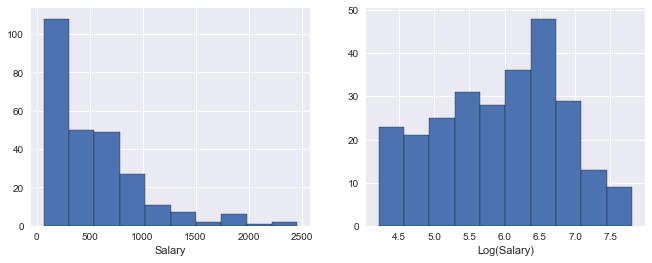

In [4]:
X = hitters[['Years', 'Hits']].as_matrix()
y = np.log(hitters.Salary.as_matrix())

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(11,4))
ax1.hist(hitters.Salary.as_matrix(),edgecolor='black')
ax1.set_xlabel('Salary')
ax2.hist(y,edgecolor='black')
ax2.set_xlabel('Log(Salary)');

In [5]:
regr = tree.DecisionTreeRegressor(max_leaf_nodes=3)
regr.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=3, min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

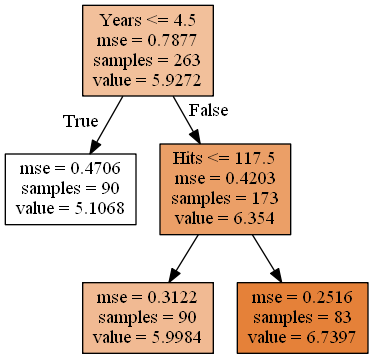

In [6]:
graph = print_tree(regr, features=['Years', 'Hits'])
Image(graph.create_png())


In [7]:
# the "value" is the log of the Salary since we transformed the original Salary with Log Transform, therefore in order to
# get the predicted value for Salary we need to find exponent of the "value"
np.exp(5.107)

165.17408858074765

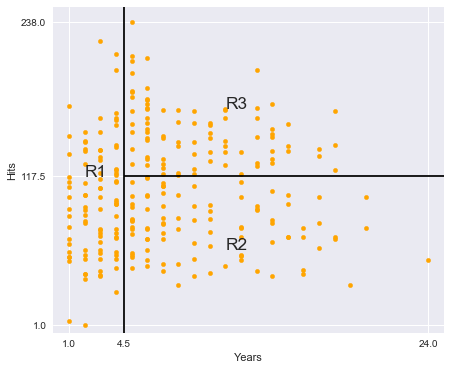

In [8]:
hitters.plot('Years', 'Hits', kind='scatter', color='orange', figsize=(7,6))
plt.xlim(0,25)
plt.ylim(ymin=-5)
plt.xticks([1, 4.5, 24])
plt.yticks([1, 117.5, 238])
plt.vlines(4.5, ymin=-5, ymax=250)
plt.hlines(117.5, xmin=4.5, xmax=25)
plt.annotate('R1', xy=(2,117.5), fontsize='xx-large')
plt.annotate('R2', xy=(11,60), fontsize='xx-large')
plt.annotate('R3', xy=(11,170), fontsize='xx-large');

## Lab 8.3.1 Fitting Classification Trees

In [47]:
carseats_df = pd.read_csv("Carseats.csv")
carseats_df.head()

,Unnamed: 0,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,1,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,2,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,3,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,4,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,5,4.15,141,64,3,340,128,Bad,38,13,Yes,No


(array([  6.,  16.,  47.,  83.,  89.,  79.,  40.,  29.,   8.,   3.]),
 array([  0.   ,   1.627,   3.254,   4.881,   6.508,   8.135,   9.762,
         11.389,  13.016,  14.643,  16.27 ]),
 <a list of 10 Patch objects>)

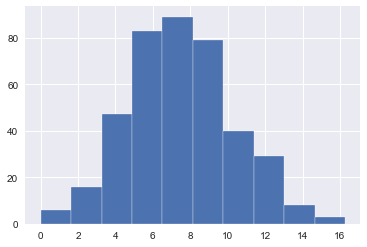

In [50]:
# Convert other string variables to numeric
carseats_df["ShelveLoc"] = pd.factorize(carseats_df["ShelveLoc"])[0]
carseats_df["Urban"] = pd.factorize(carseats_df["Urban"])[0]
carseats_df["US"] = pd.factorize(carseats_df["US"])[0]
# We want to add a binary response variable High (High Sales). We build a histogram to 
# determine the cut point.
plt.hist(carseats_df["Sales"],edgecolor='white')

In [51]:
# create a binary response variable HighSales and add to dataframe
carseats_df["High"] = carseats_df["Sales"].map(lambda x: 0 if x <= 8 else 1)
carseats_df.head()

,Unnamed: 0,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US,High
0,1,9.50,138,73,11,276,120,0,42,17,0,0,1
1,2,11.22,111,48,16,260,83,1,65,10,0,0,1
2,3,10.06,113,35,10,269,80,2,59,12,0,0,1
3,4,7.40,117,100,4,466,97,2,55,14,0,0,0
4,5,4.15,141,64,3,340,128,0,38,13,0,1,0


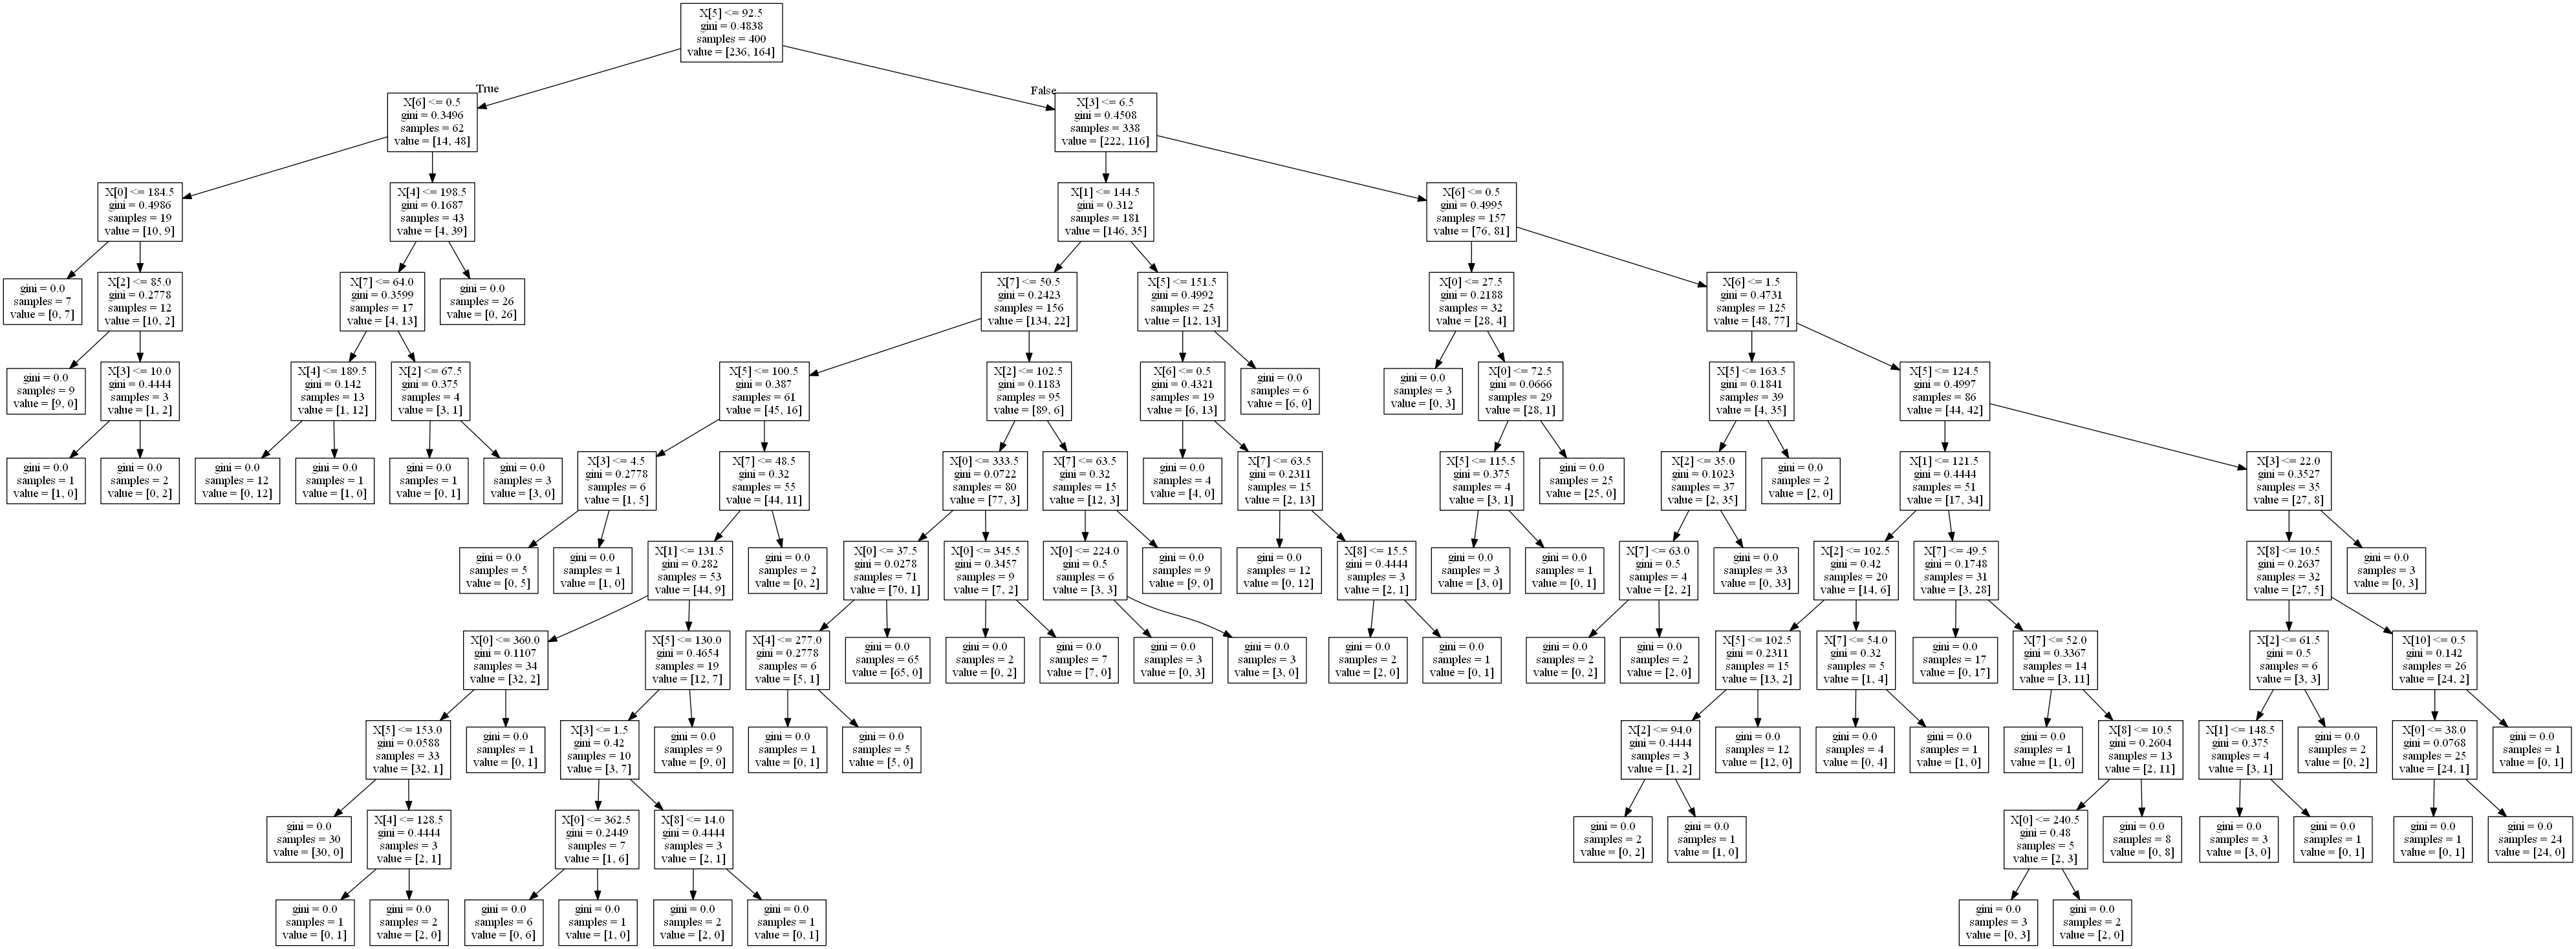

In [59]:
# fit a decision tree to predict High from the data. We remove Sales because High is
# derived from Sales and is thus correlated to the response
collist = [x for x in carseats_df.columns if x not in ('Sales', 'High')]
clf = DecisionTreeClassifier()
X = carseats_df[collist]
y = carseats_df["High"]
clf.fit(X, y)

# Visualize tree
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
print(graph)
Image(graph.create_png())

In [91]:
Xr, Xt, yr, yt = train_test_split(X, y, train_size=250, test_size=150, random_state=42)
clf = DecisionTreeClassifier()
clf.fit(Xr, yr)
ypred = clf.predict(Xt)
(confusion_matrix(yt, ypred), accuracy_score(yt, ypred))

(array([[63, 19],
        [29, 39]]), 0.68000000000000005)

Pruning can reduce overfitting. Scikit-Learn DecisionTree classifier does not support pruning currently, but one can set the minimum number of samples required at a leaf node or setting the maximum depth of the tree are necessary to avoid this problem. Here we will use cross validation with different max depths to optimize the tree.

<generator object split at 0x0000000015916438>

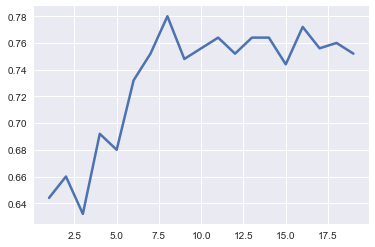

In [92]:
kfold = KFold(n_splits=10)
accs = []
max_depths = range(1, 20)
for max_depth in max_depths:
    k_accs = []
    for train, test in kfold.split(Xr):
        Xtrain, Xtest, ytrain, ytest = Xr.iloc[train], Xr.iloc[test], yr.iloc[train], yr.iloc[test]
        clf = DecisionTreeClassifier(max_depth=max_depth)
        clf.fit(Xtrain, ytrain)
        ypred = clf.predict(Xtest)
        k_accs.append(accuracy_score(ytest, ypred))
    accs.append(np.mean(k_accs))
# plot the accuracies as a function of max_depth
plt.plot(max_depths, accs, linewidth=2.5)


kfold.split(Xr)

In [10]:
# bring data from finviz.com
df = pd.read_html('http://finviz.com/screener.ashx?v=141&f=cap_large,ta_perf_ytd20o&ft=3&o=-perfytd')

,0,1,2,3,4
0,if(document.body.clientWidth>1500){document.wr...,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN


In [46]:
df[7][6:][:22].iloc[:, :12]

,0,1,2,3,4,5,6,7,8,9,10,11
6,No.,Ticker,Perf Week,Perf Month,Perf Quart,Perf Half,Perf Year,Perf YTD,Volatility W,Volatility M,Recom,Avg Volume
7,1,ARNC,-4.95%,27.73%,40.60%,29.03%,45.33%,55.70%,2.68%,3.31%,2.40,5.56M
8,2,NTES,3.96%,20.63%,34.33%,41.10%,130.27%,41.66%,4.11%,3.21%,1.80,1.08M
9,3,TSRO,-1.00%,22.44%,34.37%,117.87%,365.57%,40.07%,3.56%,4.53%,1.90,867.25K
10,4,CSX,0.04%,1.81%,39.75%,75.58%,106.47%,36.17%,2.04%,2.09%,2.20,12.10M
11,5,VALE,-10.16%,-3.00%,23.66%,91.05%,254.15%,35.83%,4.63%,3.47%,2.70,30.04M
12,6,STM,4.23%,12.29%,56.12%,103.48%,179.52%,34.45%,1.53%,1.78%,2.40,4.55M
13,7,INCY,8.78%,9.35%,23.55%,64.24%,81.09%,32.74%,2.67%,2.92%,1.70,2.03M
14,8,ILMN,3.24%,3.98%,23.83%,-2.79%,11.42%,30.74%,2.03%,1.94%,2.70,1.28M
15,9,BSBR,-3.52%,9.38%,39.39%,67.11%,213.01%,28.57%,2.07%,2.43%,4.00,1.36M
